In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from itertools import product

In [2]:
df = pd.read_csv('/home/briggsc1-erau.edu/Downloads/housing.csv')
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
target = ['median_house_value']
df = df.dropna(subset = features+target)

In [3]:
x_tr,x_te,y_tr,y_te = train_test_split(df[features],df[target],
                                       test_size = 0.4, random_state = 0)
x_va,x_te,y_va,y_te = train_test_split(x_te,y_te,
                                       test_size = 0.5, random_state = 0)

### map

map takes a function and an iterable, applies the function to each thing in the iterable, and returns a generator containing the results.

In [4]:
def double(n):
    return(2*n)
nums = [1,2,3,4]
v = map(double, nums)

for x in v: # btw the generator is single-use. to use again, redefine it.
    print(x)

2
4
6
8


### functools.reduce

functools.reduce takes a function (of two arguments) and an iterable, applies the function successively along the iterable, and returns the result.

In [8]:
from functools import reduce
def subtract(a,b):
    print(f'{a} minus {b} is {a-b}')
    return(a-b)
def add(a,b):
    return(a+b)
reduce(add,[1,2,3,4])

10

Warning: once you use an iterator once, it's used up.

Q: why does it not work to call reduce(sum,map(double,nums))?

You try: use map and reduce to get the sum of the squares up to n.

### Multiprocessing

Linux terminal: lscpu to see how many CPUs you have.

When multiprocessing, you should use at least CPUs - 1 processes. If you have 10 CPUs, use at least 9 processes. Reason: python is single-threaded. Terminal: top to see a process's id (PID), and cat /proc\/<proc id\>\/status to see the number of threads taken by a process.

In [ ]:
from multiprocessing import Pool\
def square(x):
    return(x**2)

In [14]:
%%timeit
# toy example for multiprocessing: adding up the squares from 1 to N

N=100
inpt = range(1,N+1)
with Pool(processes = 19) as p:
    res = p.map(square,inpt)
sum(res)

48.7 ms ± 658 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
res = 0
for i in range(1,N+1):
    res+=i**2
res

13.4 µs ± 3.78 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


The idea is that we create a pool of processes, then distribute (map) the function calls over the iterable input.

Here's an example where the function has two inputs. It adds up $a^b$ where $a$ ranges from 1 to 3 and $b$ ranges from 0 to 3.

In [21]:
def test(x):
    return(x[0]**x[1])
inpt = product(range(1,4),range(4))
with Pool(processes = 15) as p:
    res = p.map(test,inpt)
sum(res)

59

Now we can apply this to the problem we had last time with the absolute_error trees taking a long time to train. It will still take a few minutes (depending on how good these lab machines are), but it will be doable.

In [22]:
tr = DecisionTreeRegressor(random_state = 0)
tr.fit(x_tr,y_tr)
ud = tr.get_depth()

In [24]:
trees = []
def fit_tree(inpt):
    max_depth,min_samples_leaf = inpt
    tr = DecisionTreeRegressor(max_depth = max_depth,
                               min_samples_leaf = min_samples_leaf,
                               random_state = 0,
                               criterion = 'absolute_error')
    tr.fit(x_tr,y_tr)
    return(tr)
inpt = product(range(1,ud+1),range(1,13))
with Pool(processes = 15) as p: # adjust processes according to your hardware
    trees = p.map(fit_tree,inpt)

Now let's get trees for the other three criteria (we did this last time).

In [25]:
def fit_tree(inpt):
    max_depth,min_samples_leaf,crit = inpt
    tr = DecisionTreeRegressor(max_depth = max_depth,
                               min_samples_leaf = min_samples_leaf,
                               random_state = 0,
                               criterion = crit)
    tr.fit(x_tr,y_tr)
    return(tr)
inpt = product(range(1,ud+1),range(1,13),['squared_error','friedman_mse','poisson'])
with Pool(processes = 19) as p:
    trees2 = p.map(fit_tree,inpt)
trees = trees+trees2

Now make the dataframe of scores.

In [26]:
data = []
for tree in trees:
    tr_sc = tree.score(x_tr,y_tr)
    va_sc = tree.score(x_va,y_va)
    data.append({'crit':tree.criterion,'set':'train','score':tr_sc,'num_leaves':tree.get_n_leaves(),
                 'depth':tree.max_depth,'min_samples':tree.min_samples_leaf})
    data.append({'crit':tree.criterion,'set':'val','score':va_sc,'num_leaves':tree.get_n_leaves(),
                 'depth':tree.max_depth,'min_samples':tree.min_samples_leaf})
df_acc = pd.DataFrame(data)
# create a multi-indexed dataframe
multi = df_acc.set_index(['set','crit','depth','min_samples'])
multi = multi.sort_index()

It would be difficult to usefully plot all four criteria at once. However, we can get the information we need to comparing the criteria pairwise.

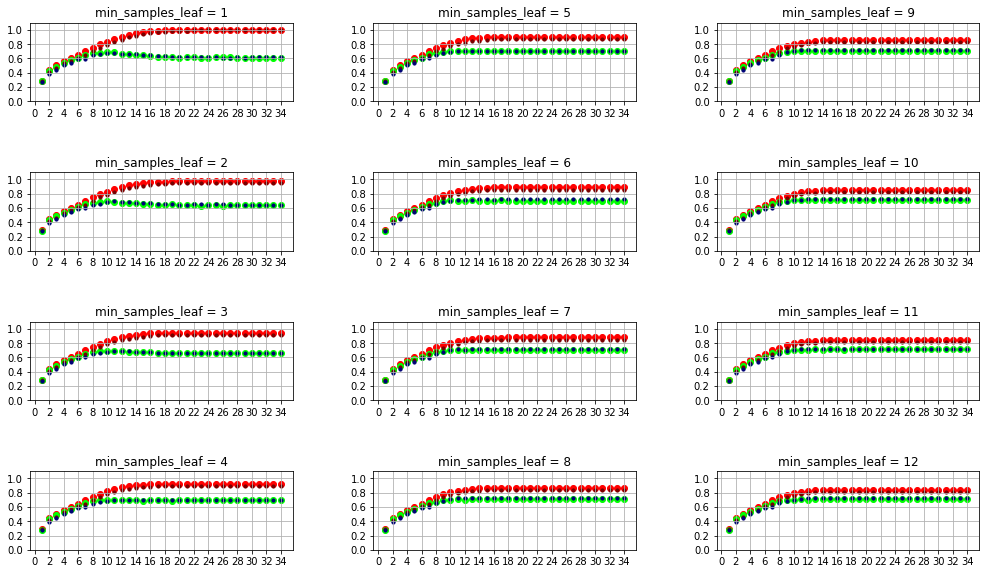

In [38]:
crit1 = 'poisson' # the bigger dots
crit2 = 'absolute_error' # the smaller dots
fig,axes = plt.subplots(4,3,figsize = (15,9))
fig.tight_layout(pad=5.0)
for j in range(12):
    axes[j%4,j//4].scatter(range(1,ud+1),multi.loc[('train',crit1,slice(None),j+1)].score,
            color = '#FF0000')
    axes[j%4,j//4].scatter(range(1,ud+1),multi.loc[('val',crit1,slice(None),j+1)].score,
            color = '#00FF00')
    axes[j%4,j//4].scatter(range(1,ud+1),multi.loc[('train',crit2,slice(None),j+1)].score,
            color = '#770000',s = 10)
    axes[j%4,j//4].scatter(range(1,ud+1),multi.loc[('val',crit2,slice(None),j+1)].score,
            color = '#000077',s = 10)
    axes[j%4,j//4].set_title(f'min_samples_leaf = {j+1}')
    axes[j%4,j//4].grid()
    axes[j%4,j//4].set_xticks(range(0,ud+1,2))
    axes[j%4,j//4].set_ylim(0,1.1)
    axes[j%4,j//4].set_yticks(np.linspace(0,1,6))
plt.show();

It's not so easy to eyeball, so we can subset the scores dataframe with set == val, then sort by score.

In [37]:
df_acc[(df_acc['set']=='val')].sort_values('score',ascending = False).head(10)

crit  set     score  num_leaves  depth  min_samples
351  absolute_error  val  0.727011        1063     15            8
303  absolute_error  val  0.726101         854     13            8
399  absolute_error  val  0.725976        1157     17            8
327  absolute_error  val  0.725891         980     14            8
307  absolute_error  val  0.725812         755     13           10
329  absolute_error  val  0.725663         899     14            9
379  absolute_error  val  0.725255         930     16           10
375  absolute_error  val  0.725002        1122     16            8
447  absolute_error  val  0.724966        1170     19            8
325  absolute_error  val  0.724838        1077     14            7

absolute_error appears to dominate. But the others aren't **that** far behind:

In [31]:
print('Best, by criterion')
print(f'    score        criterion          max_depth        min_samples_leaf')
print('  '+'-'*63)
for crit in df_acc['crit'].unique():
    idx = df_acc[(df_acc['crit']==crit)&(df_acc['set']=='val')]['score'].idxmax()
    row = df_acc.loc[idx]
    print(f'  | {round(row.score,5):<10} | {row.crit:<16} | {row.depth:<14} | {row.min_samples:>2}')

Best, by criterion
    score        criterion          max_depth        min_samples_leaf
  ---------------------------------------------------------------
  | 0.72701    | absolute_error   | 15             |  8
  | 0.72274    | squared_error    | 13             | 12
  | 0.72274    | friedman_mse     | 13             | 12
  | 0.71622    | poisson          | 15             | 10


The best option is, say, absolute_error with max_depth = 11 and min_samples_leaf = 8.

In [47]:
tr = DecisionTreeRegressor(max_depth = 13,
                           min_samples_leaf = 8,
                           criterion = 'absolute_error',
                           random_state = 0)
tr.fit(x_tr,y_tr)
tr.score(x_va,y_va)

0.7261006622126376